In [1]:
import sys; sys.path.append("../")

import os
import sys
import pickle
from model import *
from SALib.sample import sobol, saltelli
from tqdm import tqdm


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
N = 1225
mu = 10
sigma = 1
w = np.random.normal(mu, sigma, N)

In [48]:
num_comms = []
num_ccs = []
alpha_vals = np.linspace(2, 16, 32)
for alpha in tqdm(alpha_vals):
    G = construct_sda_graph(w, alpha=alpha, b=1/15)
    num_ccs.append(len(cc))
    # construct communities and augmented communities
    communities = get_communities(G)
    community_membership = get_community_membership(G, communities)

    augmented_communities = {}
    for agent in community_membership:
        comms = community_membership[agent]
        for c in comms:
            if c not in augmented_communities:
                augmented_communities[c] = {agent}
            else:
                augmented_communities[c].add(agent) 
    augmented_communities = {k:np.array(list(v)) for k,v in augmented_communities.items()}
    del augmented_communities[max(augmented_communities.keys())]
    
    num_comms.append(len(augmented_communities))

100%|██████████| 32/32 [01:29<00:00,  2.79s/it]


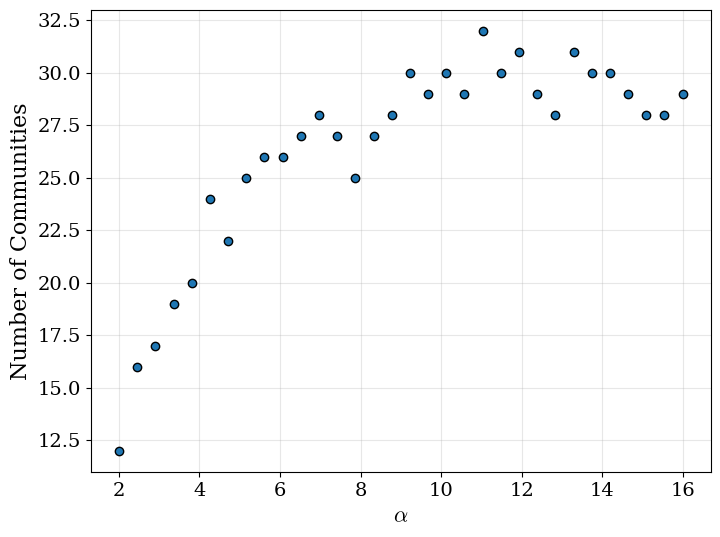

In [47]:
plt.scatter(alpha_vals, num_comms, edgecolor="k")
plt.xlabel(r"$\alpha$")
plt.ylabel("Number of Communities")
plt.show()

In [16]:
D = []
for i in range(N):
    for j in range(i+1, N):
        D.append(np.abs(w[i]-w[j]))

mean_dist = np.mean(D)
characteristic_distance = mean_dist * 1/15

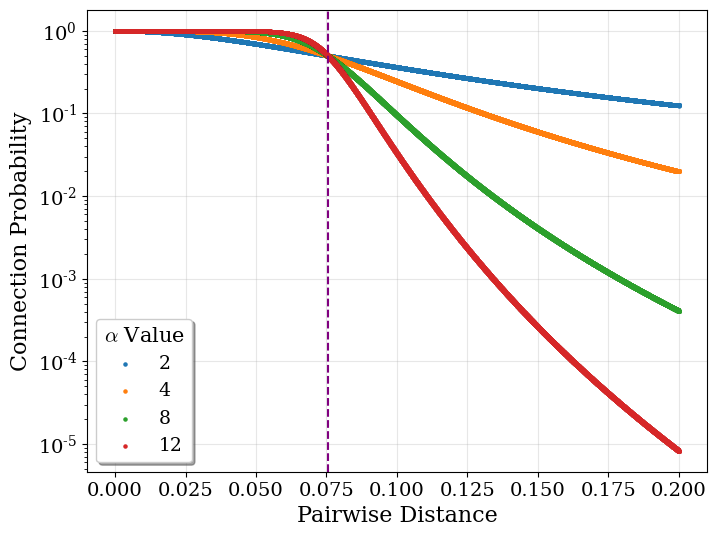

In [53]:
D = [d for d in D if d <= 0.2]

for alpha in [2, 4, 8, 12]:
    P = 1/(1+((1/characteristic_distance)*np.array(D))**alpha)
    plt.scatter(D, P, s=5, label=alpha)
    
plt.axvline(characteristic_distance, linestyle="dashed", color="purple")
plt.legend(title=r"$\alpha$ Value", shadow=True)
plt.yscale("log")
plt.xlabel("Pairwise Distance")
plt.ylabel("Connection Probability")
plt.show()

In [5]:
# problem definition
PROBLEM = {
    "num_vars" : 5,
    "names"    : ["theta",
                  "gain_right",
                  "saving_prop",
                  "prob_left",
                  "alpha"],
    "bounds"   : [[0.05, 0.95],
                  [1.70, 8.00],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [2.00, 12.0]]
}

# generate Saltelli samples
NUM_SAMPLES = 1024
X = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)

<ipython-input-5-1647d18ac9f5>:18: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)


In [6]:
unique_alpha_vals = set(X[:,-1])

In [ ]:
SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]
N     = 1225
mu    = 10
sigma = 1

for i in range(len(SEEDS)):
    
    # set random seed and generate initial wealth distribution
    s = SEEDS[i]
    random.seed(s)
    np.random.seed(s)
    w = np.random.normal(mu, sigma, N)
    
    # construct graph + extract communities for each unique alpha value
    for alpha in tqdm(unique_alpha_vals):
        G = construct_sda_graph(w, alpha=alpha)
        communities = get_communities(G)
        community_membership = get_community_membership(G, communities)
        augmented_communities = get_augmented_communities(community_membership)
        with open(f"../paper_sda_graphs/{i}_{alpha}.pickle", "wb") as f:
            pickle.dump((communities, community_membership, augmented_communities, w), f)

### Examine at gamble return distributions

1.1101742926985685 1.90129710691165 1.4380701524559831
1.1122933010118263 3.0863794355764584 1.860132169109285
1.1349908913030686 4.496429910933239 2.3498293611179646
1.107071909428537 5.932025909360397 2.852648764193272


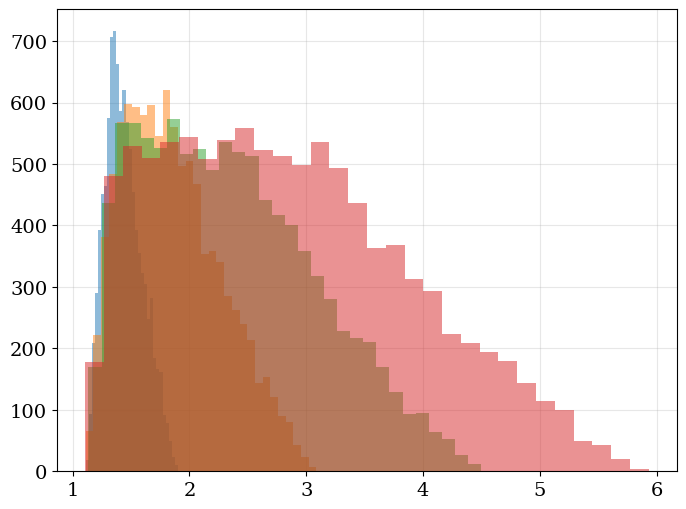

In [54]:
for r in [2.3, 4, 6, 8]:


    gambles = generate_gambles(10000, r, 0.30)

    gamble_prior_samples = np.zeros((2000, len(gambles)))
    for i,g in enumerate(gambles):
        gamble_prior_samples[:,i] = np.random.choice(g["outcomes"], 2000, p=g["probs"])
    gambles_prior_mu  = np.mean(gamble_prior_samples, axis=0)

    plt.hist(gambles_prior_mu, bins=30, alpha=0.5)
    assert min(gambles_prior_mu) >= 1.1
    print(min(gambles_prior_mu), max(gambles_prior_mu), np.mean(gambles_prior_mu))

plt.show()